# Real Topography Data Code

### Note: Lasso tests may take longer to run (5-6 min for up to 5th order poly)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from imageio import imread
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from matplotlib_scalebar.scalebar import ScaleBar

In [5]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def design_matrix(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)		# Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

# Load and Downsample Data

In [6]:
def load_data(data1, data2, downsample_factor):
    terrain1 = imread(data1)
    terrain2 = imread(data2)
    terrain1 = terrain1[::downsample_factor, ::downsample_factor]
    terrain2 = terrain2[::downsample_factor, ::downsample_factor]
    
    return terrain1, terrain2

In [7]:
downsample = 10
iowa, penn = load_data("iowa.tif", "pennsylvania.tif", downsample)

In [8]:
penn.shape

(361, 361)

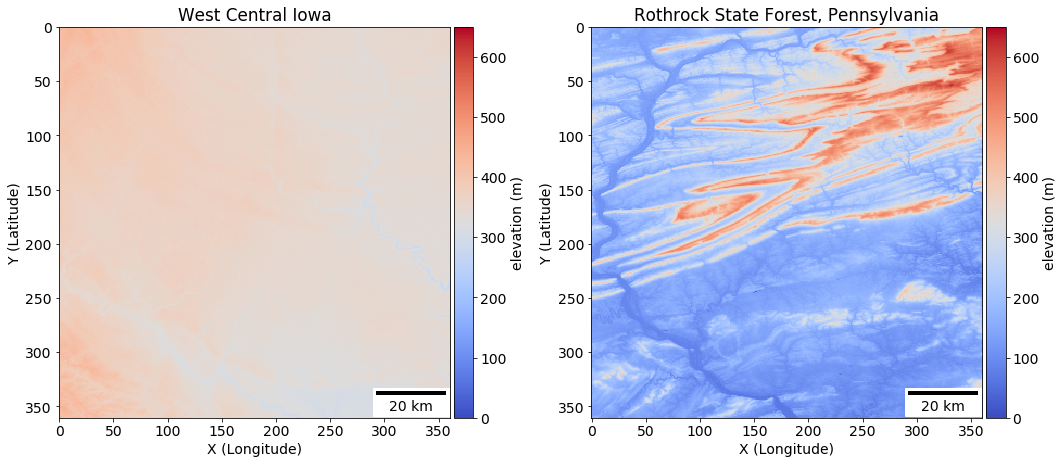

In [9]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1, 2, figsize=(15,20))

ax[0].set_title("West Central Iowa")
plot1 = ax[0].imshow(iowa, cmap='coolwarm', vmin=0, vmax=650)
ax[0].set_xlabel("X (Longitude)")
ax[0].set_ylabel("Y (Latitude)")
scalebar1 = ScaleBar(30.87*downsample, location='lower right')
ax[0].add_artist(scalebar1)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plot1, cax=cax, orientation='vertical', label='elevation (m)')

ax[1].set_title("Rothrock State Forest, Pennsylvania")
plot2 = ax[1].imshow(penn, cmap='coolwarm', vmin=0, vmax=650)
ax[1].set_xlabel("X (Longitude)")
ax[1].set_ylabel("Y (Latitude)")
scalebar2 = ScaleBar(30.87*downsample, location='lower right')
ax[1].add_artist(scalebar2)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plot2, cax=cax, orientation='vertical', label='elevation (m)')

plt.tight_layout()
#fig.savefig('topographic_maps.jpg', dpi=1000, bbox_inches='tight')

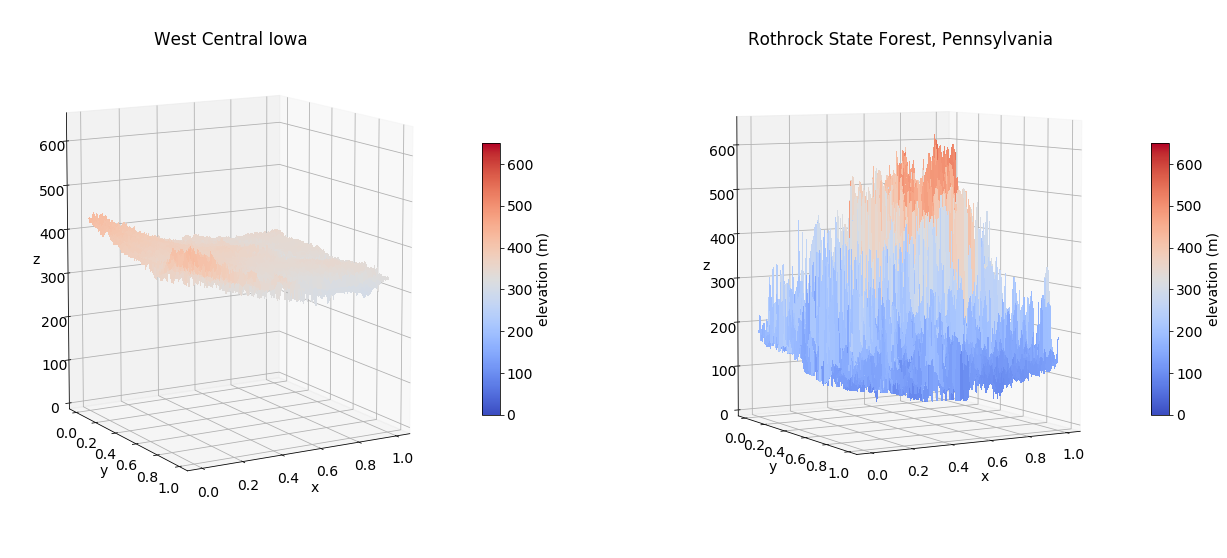

In [10]:
fig = plt.figure(figsize=(22,10))


ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
x = np.linspace(0, 1, iowa.shape[0])
y = np.linspace(0, 1, iowa.shape[1])
x_gr, y_gr = np.meshgrid(x,y)
z_iowa = iowa
surf = ax.plot_surface(x_gr, y_gr, z_iowa, cmap=cm.coolwarm, vmin=0, vmax=650,
                       linewidth=0, antialiased=False)
ax.invert_xaxis()
ax.view_init(elev=5, azim=60)
ax.set_zlim(0, 650)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')
ax.set_title('West Central Iowa')
ax.view_init(elev=10, azim=60)
fig.colorbar(surf, shrink=0.5, aspect=15, label='elevation (m)')

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

x = np.linspace(0, 1, penn.shape[0])
y = np.linspace(0, 1, penn.shape[1])
x_gr, y_gr = np.meshgrid(x,y)
z_penn = penn
surf2 = ax.plot_surface(x_gr, y_gr, z_penn, cmap=cm.coolwarm, vmin=0, vmax=650,
                       linewidth=0, antialiased=False)
ax.invert_xaxis()
ax.view_init(elev=5, azim=60)
ax.set_zlim(0, 650)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')
ax.set_title('Rothrock State Forest, Pennsylvania')
fig.colorbar(surf2, shrink=0.5, aspect=15, label='elevation (m)')
#plt.tight_layout()
#fig.savefig('topographic_maps_3D.jpg', dpi=1000, bbox_inches='tight')

# OLS with 10 fold CV

In [11]:
def real_OLS_CV(data, npointsx, npointsy, lower, upper, noise, sigma, nfolds, scaling):
    
    np.random.seed(7)
    
    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold_train = np.zeros((len(poly_order_range), k))
    scores_KFold_test = np.zeros((len(poly_order_range), k))

    x = np.linspace(0, 1, npointsx)
    y = np.linspace(0, 1, npointsy)
        
    x, y = np.meshgrid(x,y)

    z = data

    z = np.ravel(z)  
    z = (z-z.mean())/z.std()

    i = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)
        j = 0
        for train_inds, test_inds in kfold.split(X):
          
            X_train_origin = X[train_inds]
            z_train_origin = z[train_inds]
            X_test_origin = X[test_inds]
            z_test_origin = z[test_inds]

            X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
            X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
            z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
            z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)

            beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
            z_tilde = X_train @ beta
            z_pred = X_test @ beta
            
            scores_KFold_test[order-1, j] = MSE(z_pred, z_test)
            scores_KFold_train[order-1, j] = MSE(z_tilde, z_train)

            j += 1
        i += 1

    mse_KFold_test = np.mean(scores_KFold_test, axis = 1)
    mse_KFold_train = np.mean(scores_KFold_train, axis = 1)

    return mse_KFold_test, mse_KFold_train

In [12]:
npointsx = iowa.shape[0]
npointsy = iowa.shape[1]
lower_poly = 1
upper_poly = 10
noise = 0
sigma = 0.1
nfolds = 10
scaling = 1

mse_KFold_test_iowa, mse_KFold_train_iowa = real_OLS_CV(iowa, npointsx, npointsy, lower_poly, upper_poly, 
                                          noise, sigma, nfolds, scaling)

In [13]:
npointsx = penn.shape[0]
npointsy = penn.shape[1]
lower_poly = 1
upper_poly = 10
noise = 0
nfolds = 10
scaling = 1

mse_KFold_test_penn, mse_KFold_train_penn = real_OLS_CV(penn, npointsx, npointsy, lower_poly, upper_poly, 
                                          noise, sigma, nfolds, scaling)

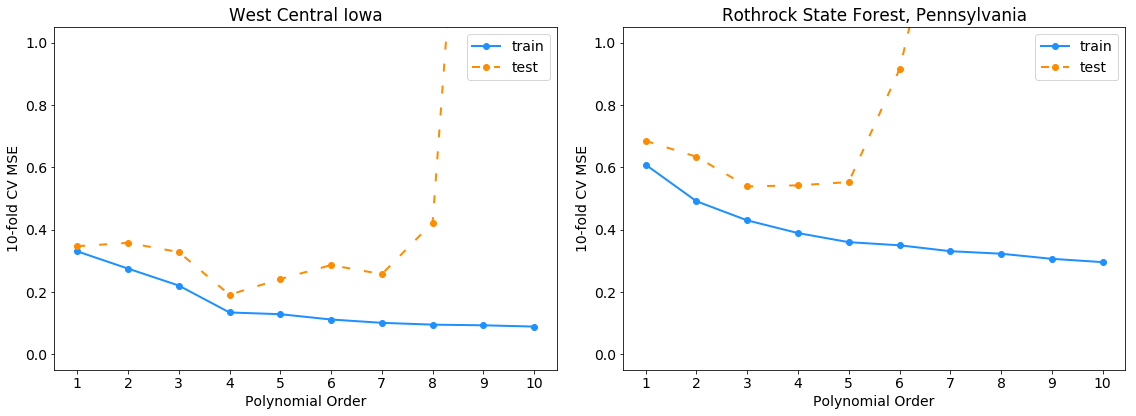

In [14]:
fig,ax = plt.subplots(1,2, figsize=(16,6))
poly_order_range = range(lower_poly, upper_poly+1)
lw=2
dashl = 4
dashs = 7
ax[0].plot(poly_order_range, mse_KFold_train_iowa, '-o', lw=lw, color='dodgerblue', label='train')
ax[0].plot(poly_order_range,mse_KFold_test_iowa, '--o', lw=lw, dashes=(dashl, dashs), color='darkorange', label='test')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_xlabel('Polynomial Order')
ax[0].set_ylabel('10-fold CV MSE')
ax[0].set_title('West Central Iowa')
ax[0].legend()
ax[0].set_ylim(-0.05, 1.05)

ax[1].plot(poly_order_range,mse_KFold_train_penn, '-o', lw=lw, color='dodgerblue', label='train')
ax[1].plot(poly_order_range,mse_KFold_test_penn, '--o', lw=lw, dashes=(dashl, dashs), color='darkorange', label='test')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_xlabel('Polynomial Order')
ax[1].set_ylabel('10-fold CV MSE')
ax[1].set_title('Rothrock State Forest, Pennsylvania')
ax[1].legend()
ax[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
#plt.savefig('real_OLS_CV.jpg', dpi=1000, bbox_inches='tight')

In [15]:
mse_KFold_test_penn

array([ 0.68481573,  0.63380181,  0.53857793,  0.54192702,  0.55250613,
        0.91425054,  1.60272824,  2.83685343, 39.14622639, 29.62401511])

In [16]:
mse_KFold_test_iowa

array([0.34666455, 0.35738475, 0.32800569, 0.19096051, 0.24132735,
       0.28599239, 0.25697828, 0.42241207, 2.63845047, 1.64377483])

# Ridge Regression

In [17]:
def real_ridge_CV(data, npointsx, npointsy, lower, upper, noise, sigma, nfolds, nlambdas, scaling):
    
    np.random.seed(7)
    
    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold_train = np.zeros((len(poly_order_range), nlambdas, k))
    scores_KFold_test = np.zeros((len(poly_order_range), nlambdas, k))

    x = np.linspace(0, 1, npointsx)
    y = np.linspace(0, 1, npointsy)
        
    x, y = np.meshgrid(x,y)

    z = data

    z = np.ravel(z)  
    z = (z-z.mean())/z.std()
    count = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)
    
        lambdas = np.logspace(-4, 1, nlambdas)
        
        for i in range(nlambdas):
            
            lmb = lambdas[i]
            j = 0
            for train_inds, test_inds in kfold.split(X):
                
                X_train_origin = X[train_inds]
                z_train_origin = z[train_inds]
                X_test_origin = X[test_inds]
                z_test_origin = z[test_inds]

                X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
                X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
                z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
                z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)
                
                I = np.eye(X_train.shape[1],X_train.shape[1])

                beta = np.linalg.pinv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
                z_tilde = X_train @ beta
                z_pred = X_test @ beta

                scores_KFold_test[order-1, i, j] = MSE(z_pred, z_test)
                scores_KFold_train[order-1, i, j] = MSE(z_tilde, z_train)

                j += 1
            i += 1
        count += 1    
        print(str(count)+'/'+str(len(poly_order_range)))

    mse_KFold_test = np.mean(scores_KFold_test, axis = 2)
    mse_KFold_train = np.mean(scores_KFold_train, axis = 2)

    return mse_KFold_test, mse_KFold_train


### Iowa Ridge

In [18]:
npointsx = iowa.shape[0]
npointsy = iowa.shape[1]
lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 1
nlambdas = 20
lambdas = np.logspace(-4, 1, nlambdas)
nfolds = 10
test_MSEs_iowa_ridge, train_MSEs_iowa_ridge = real_ridge_CV(iowa, npointsx, npointsy, 
                                              lower_poly, upper_poly, noise, sigma, nfolds, nlambdas, scaling)

1/5
2/5
3/5
4/5
5/5


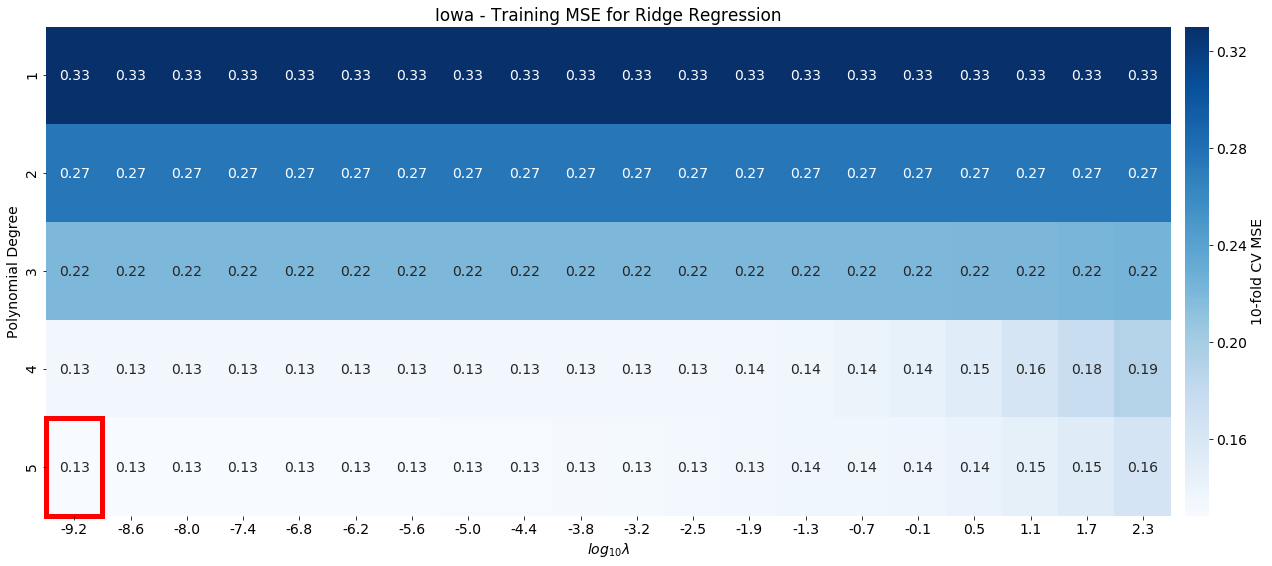

In [19]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(train_MSEs_iowa_ridge, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(train_MSEs_iowa_ridge)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Iowa - Training MSE for Ridge Regression")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('iowa_ridge_train.jpg', dpi=1000, bbox_inches='tight')

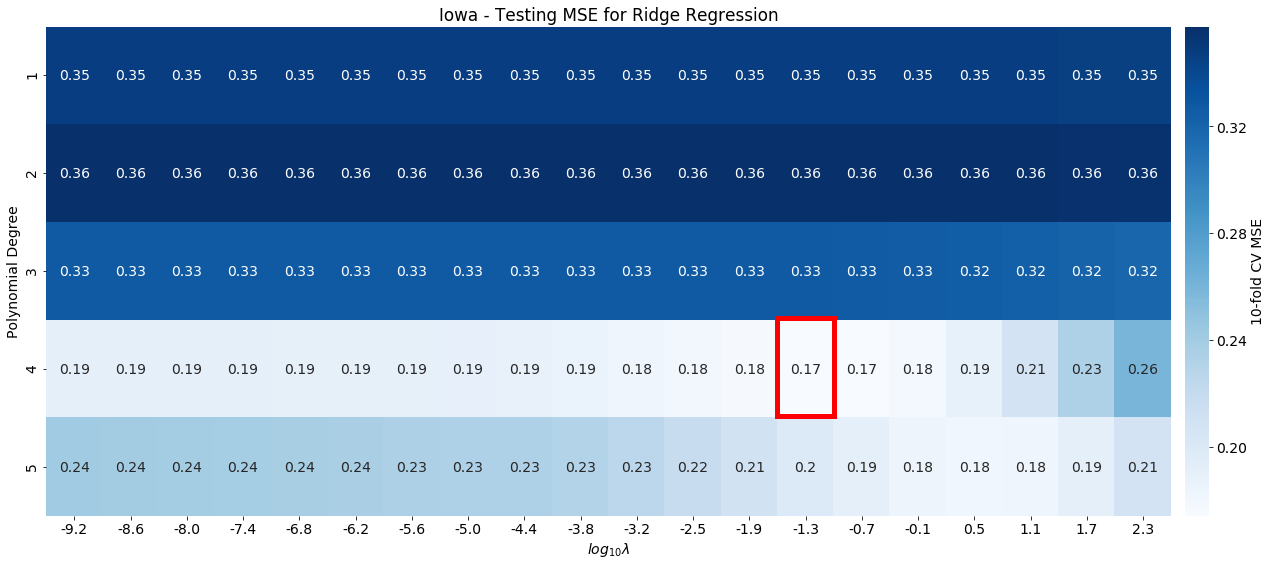

In [20]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(test_MSEs_iowa_ridge, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(test_MSEs_iowa_ridge)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/24.5), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Iowa - Testing MSE for Ridge Regression")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('iowa_ridge_test.jpg', dpi=1000, bbox_inches='tight')

### Penn Ridge

In [21]:
npointsx = penn.shape[0]
npointsy = penn.shape[1]
lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 1
nlambdas = 20
nfolds = 10
lambdas = np.logspace(-4, 1, nlambdas)
test_MSEs_penn_ridge, train_MSEs_penn_ridge = real_ridge_CV(penn, npointsx, npointsy, 
                                              lower_poly, upper_poly, noise, sigma, nfolds, nlambdas, scaling)

1/5
2/5
3/5
4/5
5/5


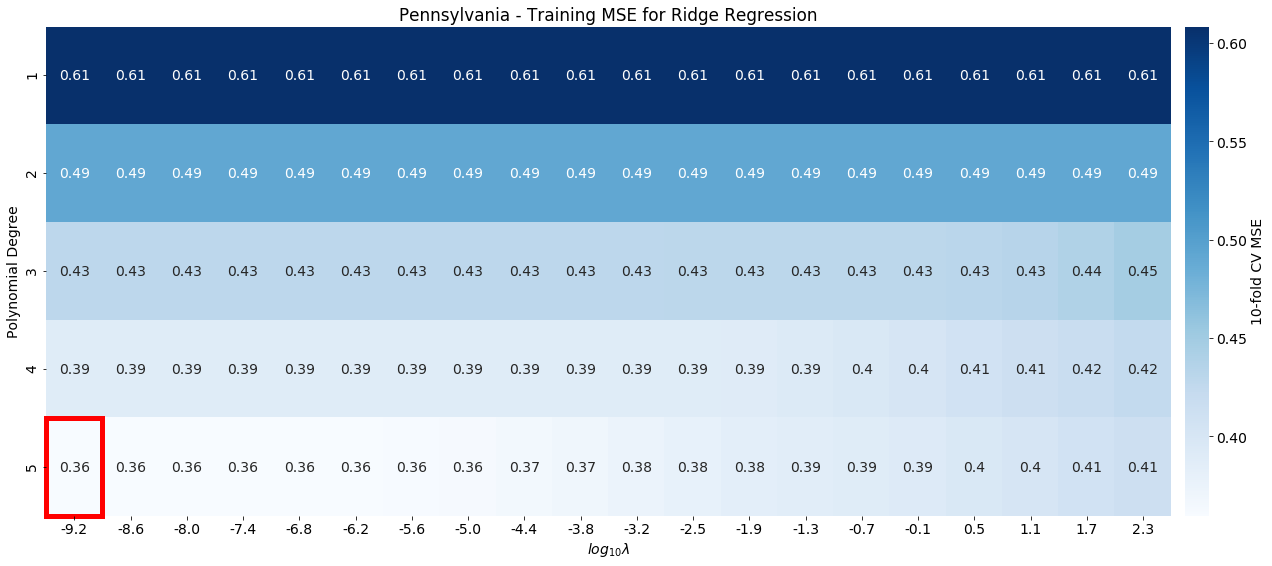

In [22]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(train_MSEs_penn_ridge, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(train_MSEs_penn_ridge)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Pennsylvania - Training MSE for Ridge Regression")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('penn_ridge_train.jpg', dpi=1000, bbox_inches='tight')

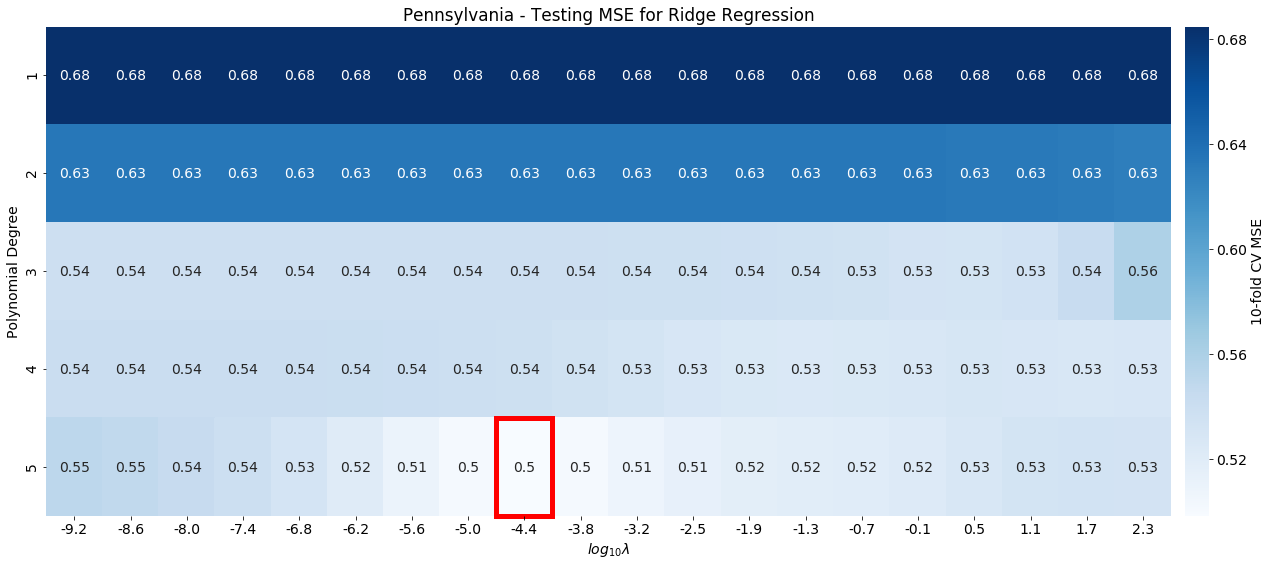

In [23]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(test_MSEs_penn_ridge, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(test_MSEs_penn_ridge)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/22), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Pennsylvania - Testing MSE for Ridge Regression")
ax.set_xticklabels(np.log(lambdas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\lambda}$")
#fig.savefig('penn_ridge_test.jpg', dpi=1000, bbox_inches='tight')

# Lasso Regression

In [24]:
def real_lasso_CV(data, npointsx, npointsy, lower, upper, noise, sigma, nfolds, nalphas, scaling):

    np.random.seed(1)

    poly_order_range = range(lower, upper+1)
    k = nfolds
    kfold = KFold(n_splits = k)
    scores_KFold_train = np.zeros((len(poly_order_range), nalphas, k))
    scores_KFold_test = np.zeros((len(poly_order_range), nalphas, k))

    x = np.linspace(0, 1, npointsx)
    y = np.linspace(0, 1, npointsy)
        
    x, y = np.meshgrid(x,y)

    z = data

    z = np.ravel(z)  
    z = (z-z.mean())/z.std()
    count = 0
    for order in poly_order_range:

        X = design_matrix(x, y, order)

        alphas = np.logspace(-4, 1, nalphas)

        for i in range(nalphas):

            alp = alphas[i]
            j = 0
            for train_inds, test_inds in kfold.split(X):

                X_train_origin = X[train_inds]
                z_train_origin = z[train_inds]
                X_test_origin = X[test_inds]
                z_test_origin = z[test_inds]

                X_train = X_train_origin - scaling * np.mean(X_train_origin, axis=0)
                X_test = X_test_origin - scaling * np.mean(X_train_origin, axis=0)
                z_train = z_train_origin - scaling * np.mean(z_train_origin, axis=0)
                z_test = z_test_origin - scaling * np.mean(z_train_origin, axis=0)

                model = Lasso(alpha = alp)
                model.fit(X_train, z_train)

                ztilde_Lasso = model.predict(X_train)
                zpredict_Lasso = model.predict(X_test)

                scores_KFold_test[order-1, i, j] =  MSE(zpredict_Lasso, z_test)
                scores_KFold_train[order-1, i, j] =  MSE(ztilde_Lasso, z_train)

                j += 1
            i += 1

        count += 1
        print(str(count)+'/'+str(len(poly_order_range)))

    estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 2)
    estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 2)

    return estimated_mse_KFold_test, estimated_mse_KFold_train

### Iowa Lasso

In [25]:
npointsx = iowa.shape[0]
npointsy = iowa.shape[1]
lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 1
nfolds = 10
nalphas = 20
alphas = np.logspace(-4, 1, nalphas)
test_MSEs_iowa_lasso, train_MSEs_iowa_lasso = real_lasso_CV(iowa, npointsx, npointsy, lower_poly, upper_poly, 
                                            noise, sigma, nfolds, nalphas, scaling)

1/5
2/5
3/5
4/5
5/5


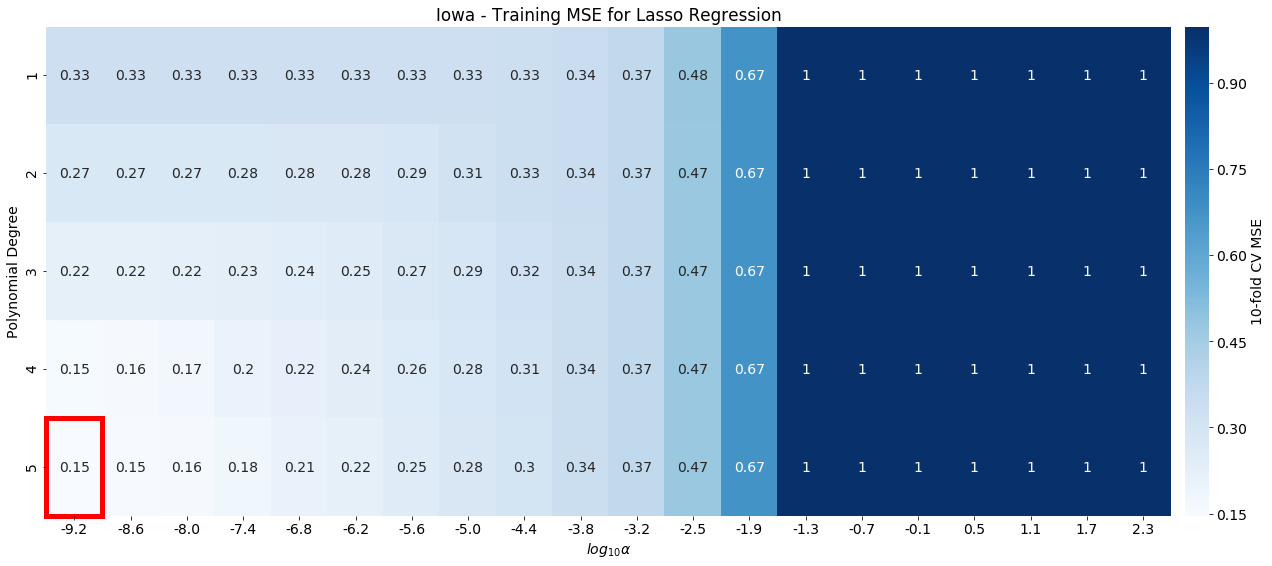

In [26]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(train_MSEs_iowa_lasso, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(train_MSEs_iowa_lasso)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Iowa - Training MSE for Lasso Regression")
ax.set_xticklabels(np.log(alphas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\alpha}$")
#fig.savefig('iowa_lasso_train.jpg', dpi=1000, bbox_inches='tight')

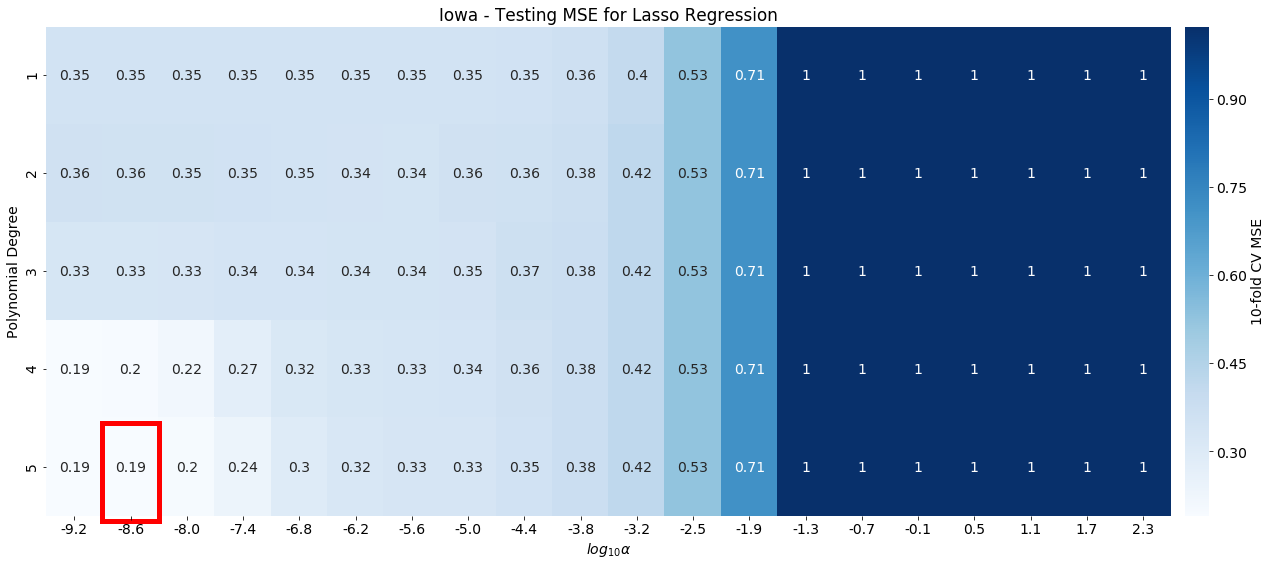

In [27]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(test_MSEs_iowa_lasso, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(test_MSEs_iowa_lasso)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Iowa - Testing MSE for Lasso Regression")
ax.set_xticklabels(np.log(alphas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\alpha}$")
#fig.savefig('iowa_lasso_test.jpg', dpi=1000, bbox_inches='tight')

### Penn Lasso

In [28]:
npointsx = penn.shape[0]
npointsy = penn.shape[1]
lower_poly = 1
upper_poly = 5
noise = 0
sigma = 0
scaling = 1
nfolds = 10
nalphas = 20
alphas = np.logspace(-4, 1, nalphas)
test_MSEs_penn_lasso, train_MSEs_penn_lasso = real_lasso_CV(penn, npointsx, npointsy, lower_poly, upper_poly, 
                                            noise, sigma, nfolds, nalphas, scaling)

1/5
2/5
3/5
4/5
5/5


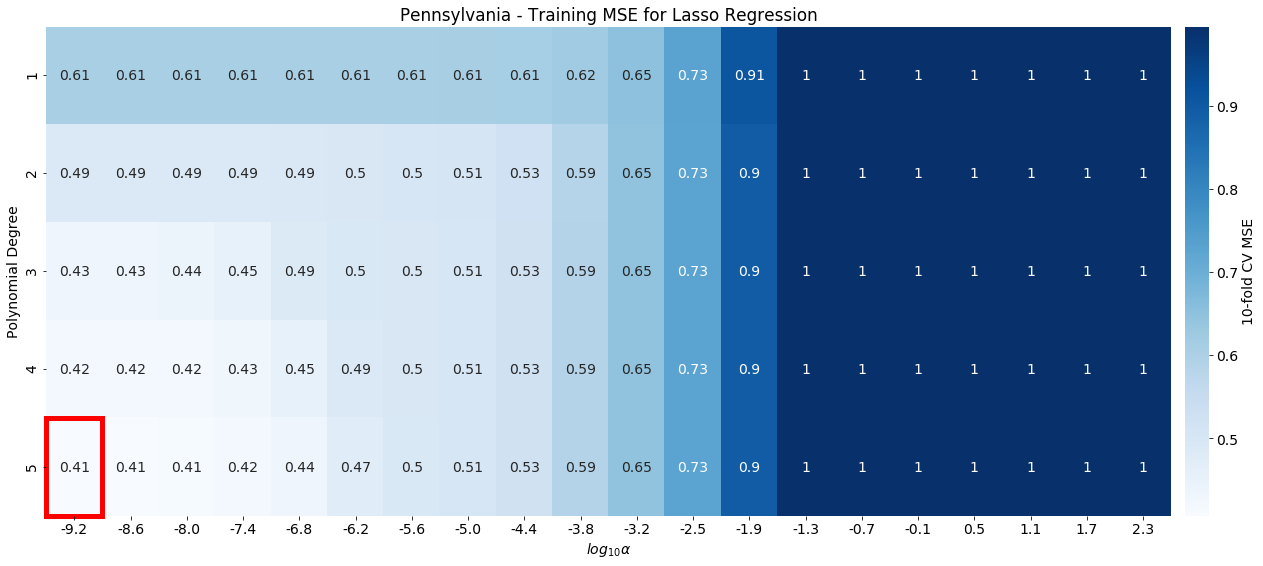

In [29]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(train_MSEs_penn_lasso, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(train_MSEs_penn_lasso)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Pennsylvania - Training MSE for Lasso Regression")
ax.set_xticklabels(np.log(alphas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\alpha}$")
#fig.savefig('penn_lasso_train.jpg', dpi=1000, bbox_inches='tight')

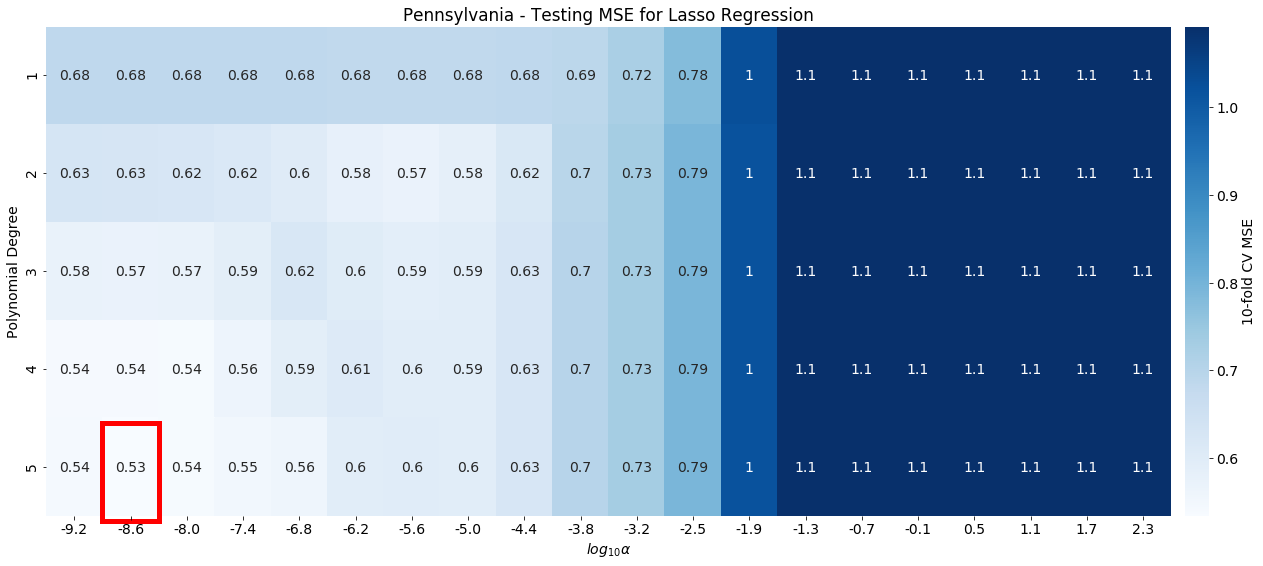

In [30]:
fig, ax = plt.subplots(figsize=(24,9))
sns.heatmap(test_MSEs_penn_lasso, annot=True, ax=ax, cmap="Blues", cbar_kws={'label': '10-fold CV MSE', 'pad': .01})
min_ent = np.argmin(test_MSEs_penn_lasso)
ax.add_patch(plt.Rectangle((min_ent%20, min_ent/20), 1, 1, fc='none', ec='red', lw=5, clip_on=False))
ax.set_title("Pennsylvania - Testing MSE for Lasso Regression")
ax.set_xticklabels(np.log(alphas).round(1))
ax.set_yticklabels(range(1,6))
ax.set_ylabel("Polynomial Degree")
ax.set_xlabel("$log_{10}{\\alpha}$")
#fig.savefig('penn_lasso_test.jpg', dpi=1000, bbox_inches='tight')